In [13]:
from ipywidgets import interact, IntSlider
import pickle

## Import The Data

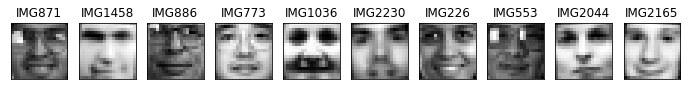

In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np

data_path = './face/'
imgs = []
fs = (12, 12)

filenames = sorted(os.listdir(data_path))
d = [] # vector of classification labels
data = np.empty((19*19,1))

for img_name in filenames:
    if img_name.endswith(".pgm"):
        img = plt.imread(data_path + img_name)
        if len(img.shape)>2:
            img = img[:,:,0]   
        imgs.append(img)
        d.append(int(img_name[5:-5]))

imgs = np.asarray(imgs)
d = np.asarray(d)
indices = np.random.randint(0, len(imgs)-1, 10)        
plt.figure(figsize=fs)

for i,im in enumerate(imgs[indices]):
    plt.subplot(1, 10, i+1)
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.title('IMG' + str(indices[i]))
plt.show()

imgs = imgs.reshape((imgs.shape[0],-1)).T

In [16]:
def Sparseness(W, dim=0):
    (a,b) = W.shape
    rng = b
    num = a
    Matr = np.copy(W)
    if dim==1:
        rng = a
        num = b
        Matr = np.copy(W.T)
    vals = []
    for i in range(num):
        tmp = (np.sqrt(rng)-(np.sum(np.absolute(Matr[i]))/np.sqrt(np.sum(Matr[i]**2,0))))/(np.sqrt(rng)-1)
        vals.append(tmp)
        
    return np.average(np.asarray(vals))

<img src="./images/StopKriteri.png">

In [ ]:
def ProjectedGradient(X, W, H):
    grd = W.T.dot(W).dot(H)-W.T.dot(X)
    V = np.zeros_like(H)
    for i in range(H.shape[0]):
        if len(H.shape) > 1:
            for j in range(H.shape[1]):
                if H[i,j] == 0:
                    V[i,j] = min([0,grd[i,j]])
                elif H[i,j] > 0:
                    V[i,j] =  grd[i,j]
                else:
                    print('Negative value of H')
        else:
            if H[i] == 0:
                V[i] = min([0,grd[i]])
            elif H[i] > 0:
                V[i] =  grd[i]
            else:
                print('Negative value of H')
    return np.sqrt(np.sum(V**2))

Purpose of APG is to solve the following:
<img src="./images/Purpose_of_APG.png">

<img src="./images/APG.png">

<img src="./images/Der_of_1.png">

In [24]:
def APG(X, A, H_k, maxiter=50):
    Y_k = H_k.copy()
    alpha_0 = 1
    k = 0
    L = np.sum(A.T.dot(A)**2)
    itr = 0
    err_l =[]
    err = 1
    pg0 = ProjectedGradient(X, A, H_k)
    epH = pg0/np.sqrt(np.sum((A.T.dot(A).dot(H_k)-A.T.dot(X))**2))
#    print('epH: %f' %epH)
    pg = pg0
#    print('pg0: %f' %pg0)
    cnt = 0
    while itr<maxiter and pg >= max((epH,10e-3))*pg0:
        itr +=1
        cnt += 1 
        H_k1 = Y_k-(1/L)*(A.T.dot(A).dot(Y_k)-A.T.dot(X))
        
#        H_k1 = (Y_k-(1/L)*np.einsum("aj,aj,ji->ji", A, A, Y_k) - A.T.dot(X))
        H_k1[H_k1<0] = 0
        
        alpha = (1+np.sqrt(4*alpha_0**2+1))/2
        Y_k1 = H_k1 + (alpha_0-1)/(alpha)*(H_k1-H_k)
        alpha_0 = alpha
        H_k = np.copy(H_k1)
        Y_k = Y_k1.copy()
        err = np.average(np.sqrt((X-A.dot(H_k))**2))
        err_l.append(err)
        pg = ProjectedGradient(X, A, H_k)
        if (pg <= max((epH,10e-3))*pg0 and cnt<10):
            epH = 0.1*epH
            cnt = 0
#        print('pg: %f' %pg)
#        if (itr%50 == 0 ):
#            print(itr)
#    print(itr)
    return H_k, err_l

def MUR(X, A, H):
    return H*(A.T.dot(X)/A.T.dot(A).dot(H))

def MUR_err(X, A, H, maxiter = 50):
    itr=0
    err_l = []
    while (itr<maxiter):
        H = H*(A.T.dot(X)/A.T.dot(A).dot(H))
        err = np.average(np.sqrt((X-A.dot(H))**2))
        err_l.append(err)
        itr +=1
        
    return H, err_l

### Example of Accelerated Proximal Gradient 

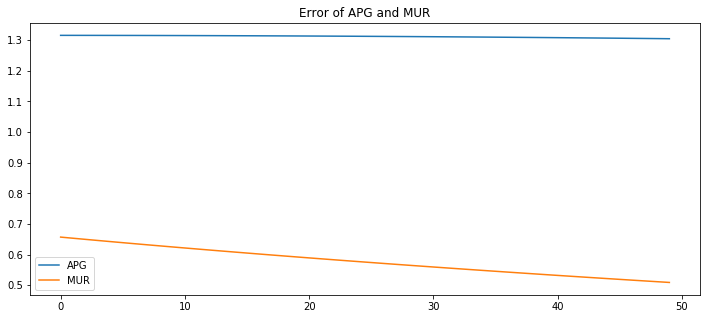

249898.94679642448


In [25]:
np.random.seed(1)
H_b = np.random.rand(50,400)
A = np.random.rand(2500,50)
X= A.dot(H_b)
X

np.random.seed(50)
H, err_apg = APG(X,A, np.random.rand(50,400))
np.random.seed(50)
H_m, err_mur = MUR_err(X,A, np.random.rand(50,400))

plt.figure(figsize=(12,5))
plt.title('Error of APG and MUR')
plt.plot(err_apg)
plt.plot(err_mur)
plt.legend(('APG','MUR'))
plt.show()

print(ProjectedGradient(X, A, H))


## NFM and Non-Smooth NMF

In [3]:
def NMF(X, M, rank, div = 'Euclidian', maxiter= 500):
    (a,b) = X.shape
    np.random.seed(100)
    Z = np.random.rand(a, rank)
    H = np.random.rand(rank, b)
    
    err = np.average(np.sqrt((X-np.dot(Z,H))**2))
    itr = 0
    e = []
    sZ = []
    sH = []
    while itr < maxiter:       
        H = H* (np.dot(Z.T,X)/ np.dot(np.dot(Z.T,Z),H))
        Z = Z * (X.dot(H.T)/Z.dot(H).dot(H.T))
        itr +=1
        err = np.average(np.sqrt((X-np.dot(Z,H))**2))
        sZ.append(Sparseness(Z,0))
        sH.append(Sparseness(H,1))
        e.append(err)
        if (itr%100 == 0):
            print(itr)
    print('Error: ' + str(err))
    print('Sparseness of Z: ' + str(Sparseness(Z,0)))
    print('Sparseness of H: ' + str(Sparseness(H,1)))
    return e, Z, H, sZ, sH

def NSNMF(X, M, rank, theta = 0.5,div = 'Euclidian', maxiter= 500, opt_mode = 'MUR'):
    (a,b) = X.shape
    np.random.seed(100)
    Z = np.random.rand(a, rank)
    H = np.random.rand(rank, b)
    S = np.identity(rank)*(1-theta)+(theta/rank)*np.ones((rank,rank))
    
    err = np.average(np.sqrt((X-Z.dot(S).dot(H))**2))
    itr = 0
    e = []
    sZ = []
    sH = []
    while itr < maxiter:       
        if opt_mode=='MUR':
            H = MUR(X, Z.dot(S), H)
            tmp = MUR(X.T, S.dot(H).T , Z.T)
            Z = tmp.T
        else:
            H,_ = APG(X, Z.dot(S), H)
            tmp,_ = APG(X.T, S.dot(H).T , Z.T)
            Z = tmp.T

#        H = H* (np.dot(Z.dot(S).T,X)/ np.dot(np.dot(Z.dot(S).T,Z.dot(S)),H))
#        Z = Z * (X.dot(S.dot(H).T)/Z.dot(S.dot(H)).dot(S.dot(H).T))
        itr +=1
        err = np.average(np.sqrt((X-Z.dot(S).dot(H))**2))
        sZ.append(Sparseness(Z,0))
        sH.append(Sparseness(H,1))
        e.append(err)
        if (itr%100 == 0):
            print(itr)
    print('Error: ' + str(err))
    print('Sparseness of Z: ' + str(Sparseness(Z,0)))
    print('Sparseness of H: ' + str(Sparseness(H,1)))
    return e, Z, H, S, sZ, sH

In [4]:
#rank = 10
#
#print('NMF')
#en,Zn,Hn, sZn,sHn = NMF(imgs, np.ones(im.shape), rank)
#
#print('NSNMF')
#ens,Zns,Hns, _, sZns,sHns = NSNMF(imgs, np.ones(im.shape), rank)

#with open('NMF_NSNMF.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([rank, en,Zn,Hn, sZn,sHn,ens,Zns,Hns, sZns,sHns ], f)
    
with open('NMF_NSNMF.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    [rank, en,Zn,Hn, sZn,sHn,ens,Zns,Hns, sZns,sHns ] = pickle.load(f)


### Comparison of Error and Sparseness

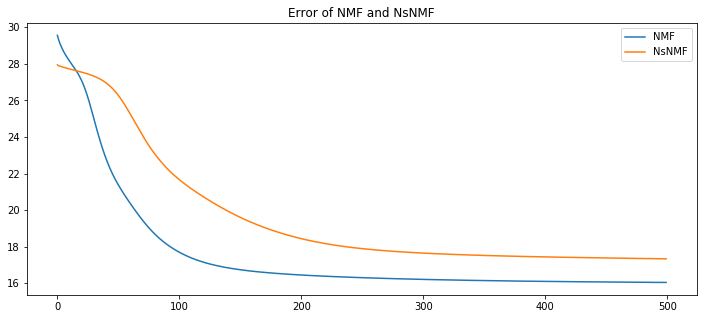

In [17]:
plt.figure(figsize=(12,5))
plt.title('Error of NMF and NsNMF')
plt.plot(en)
plt.plot(ens)
plt.legend(('NMF','NsNMF'))
plt.show()

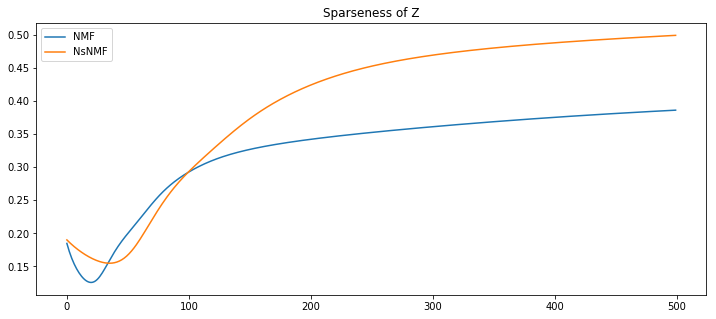

In [6]:
plt.figure(figsize=(12,5))
plt.title('Sparseness of Z')
plt.plot(sZn)
plt.plot(sZns)
plt.legend(('NMF','NsNMF'))
plt.show()

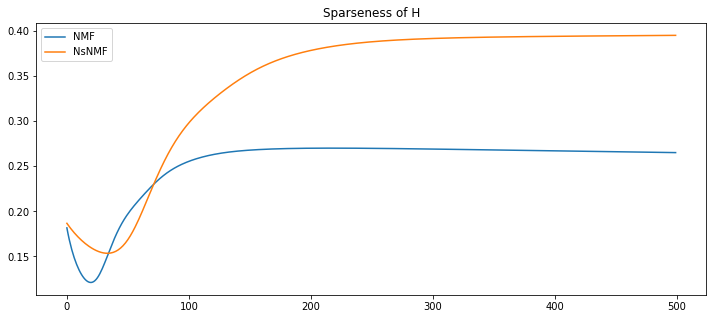

In [7]:
plt.figure(figsize=(12,5))
plt.title('Sparseness of H')
plt.plot(sHn)
plt.plot(sHns)
plt.legend(('NMF','NsNMF'))
plt.show()

### Extracted Features of NMF and NsNMF

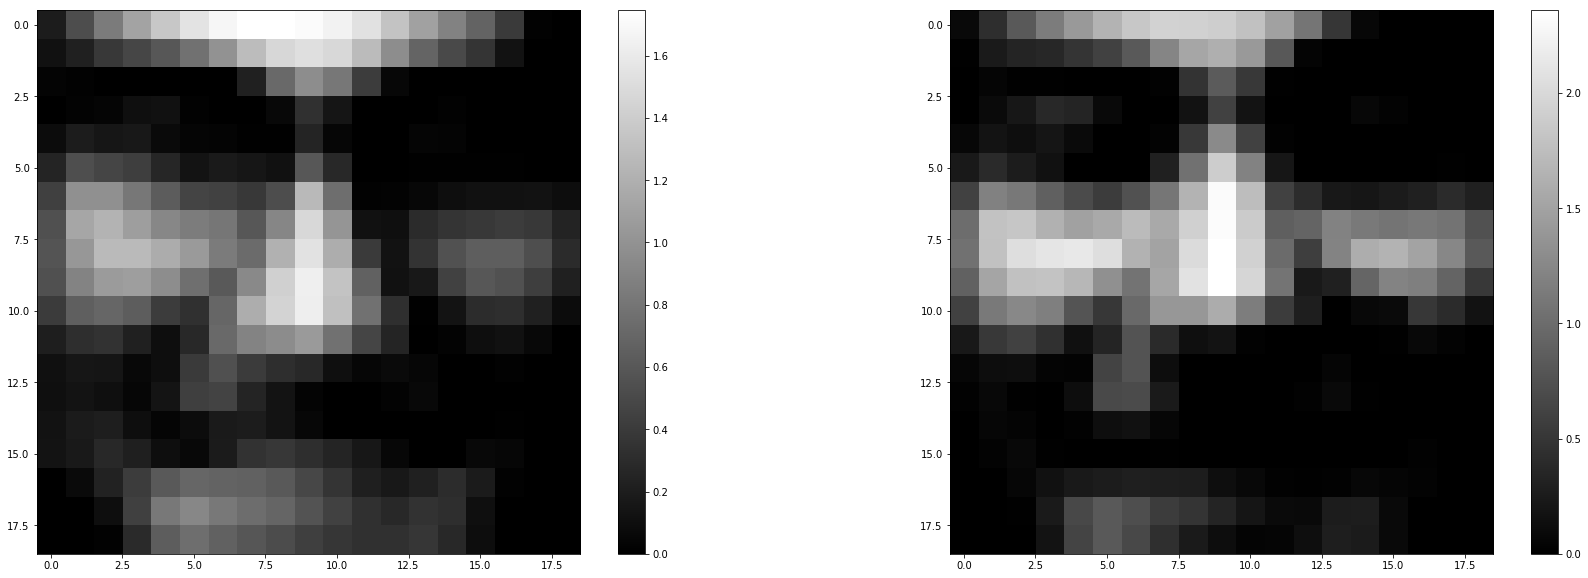

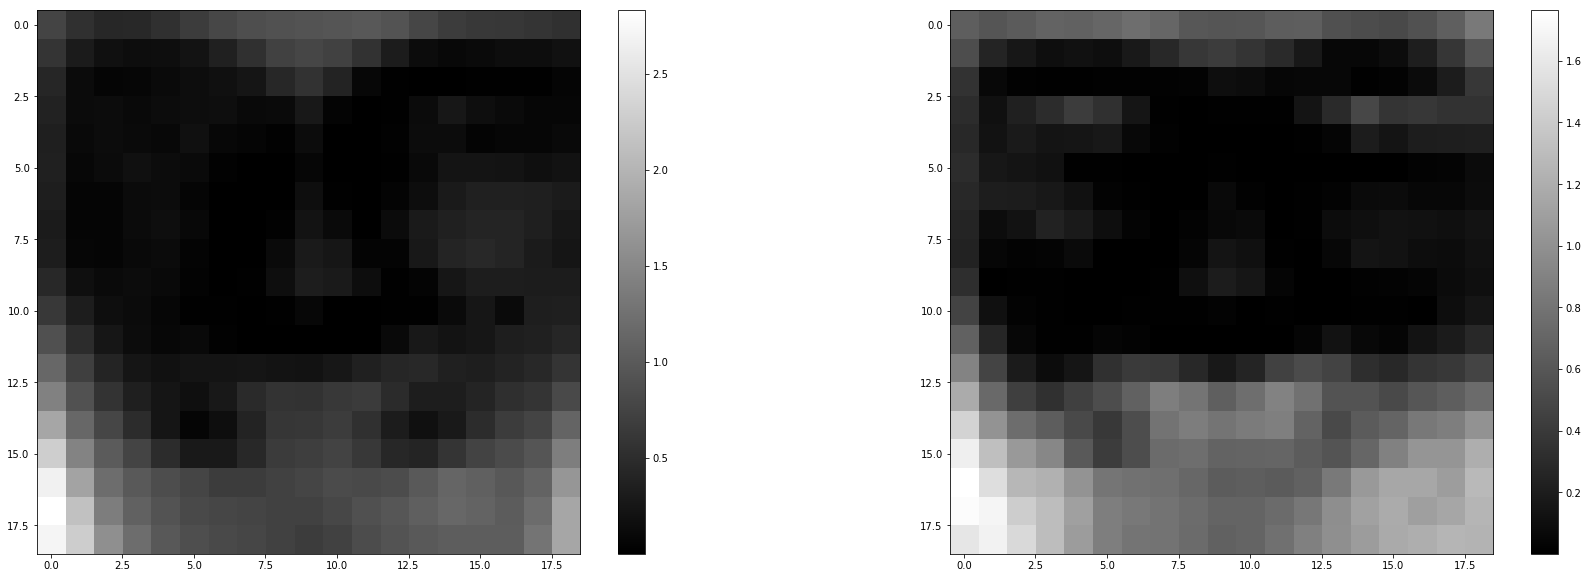

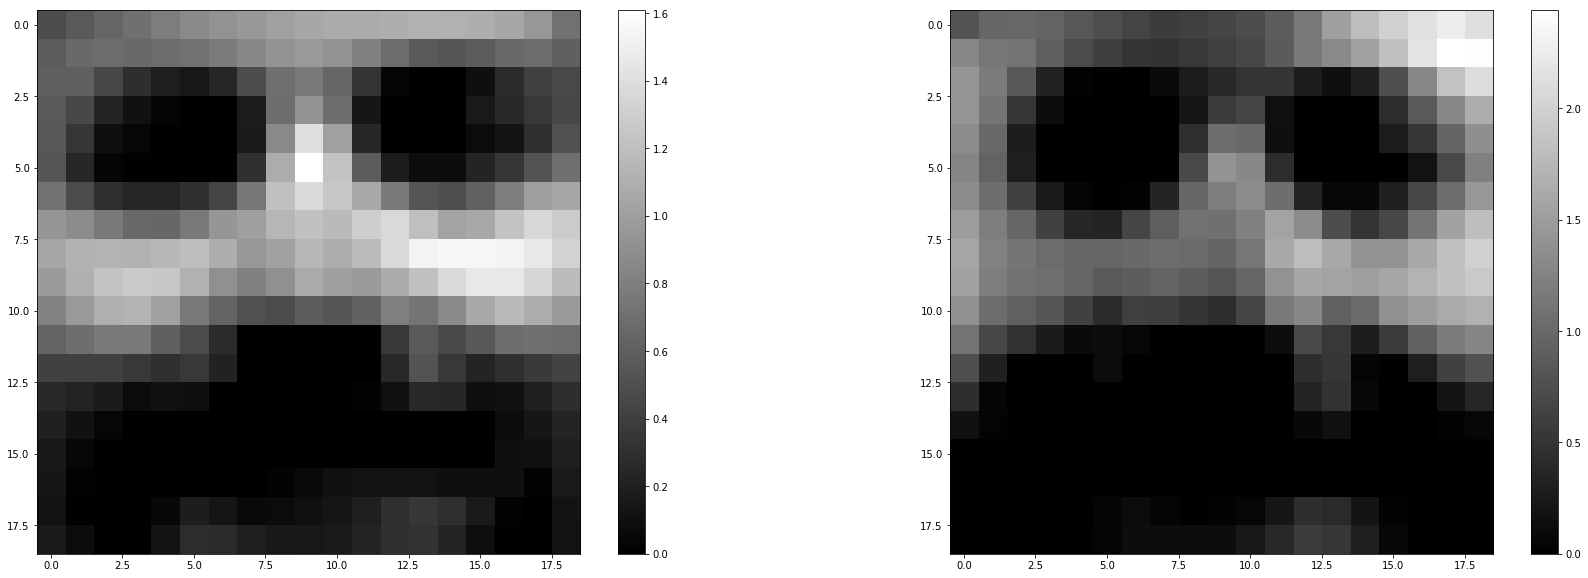

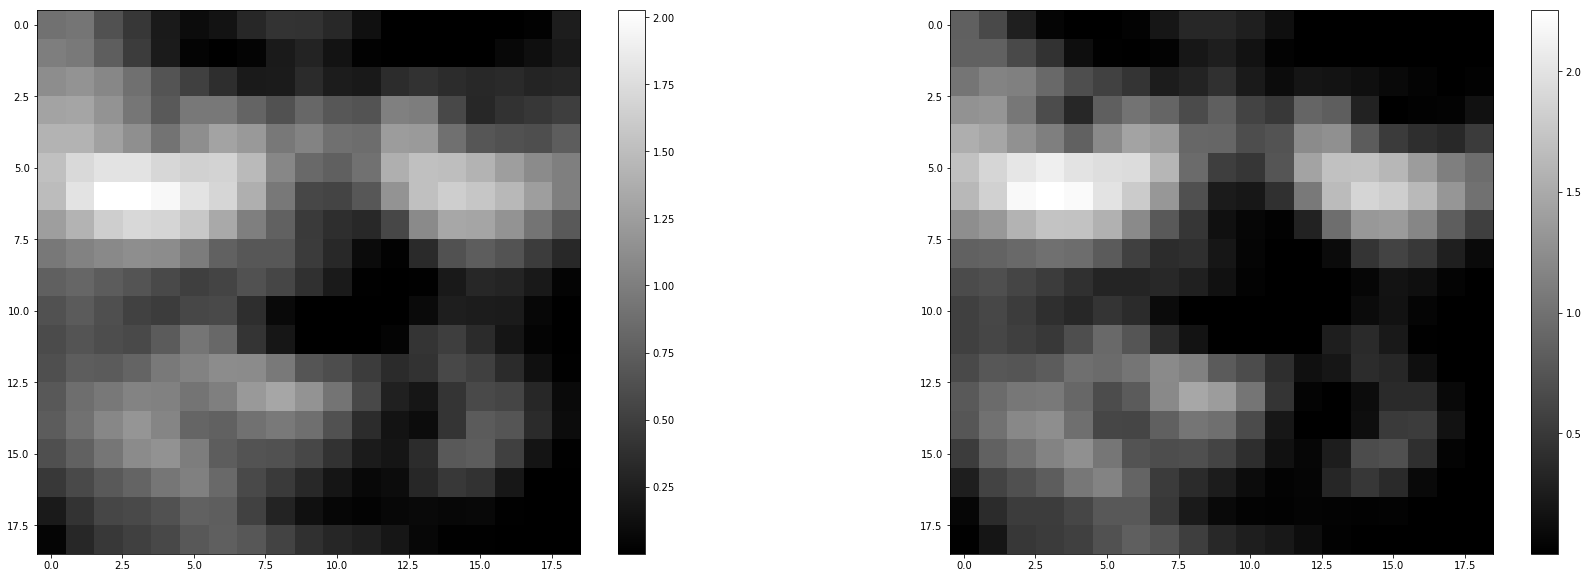

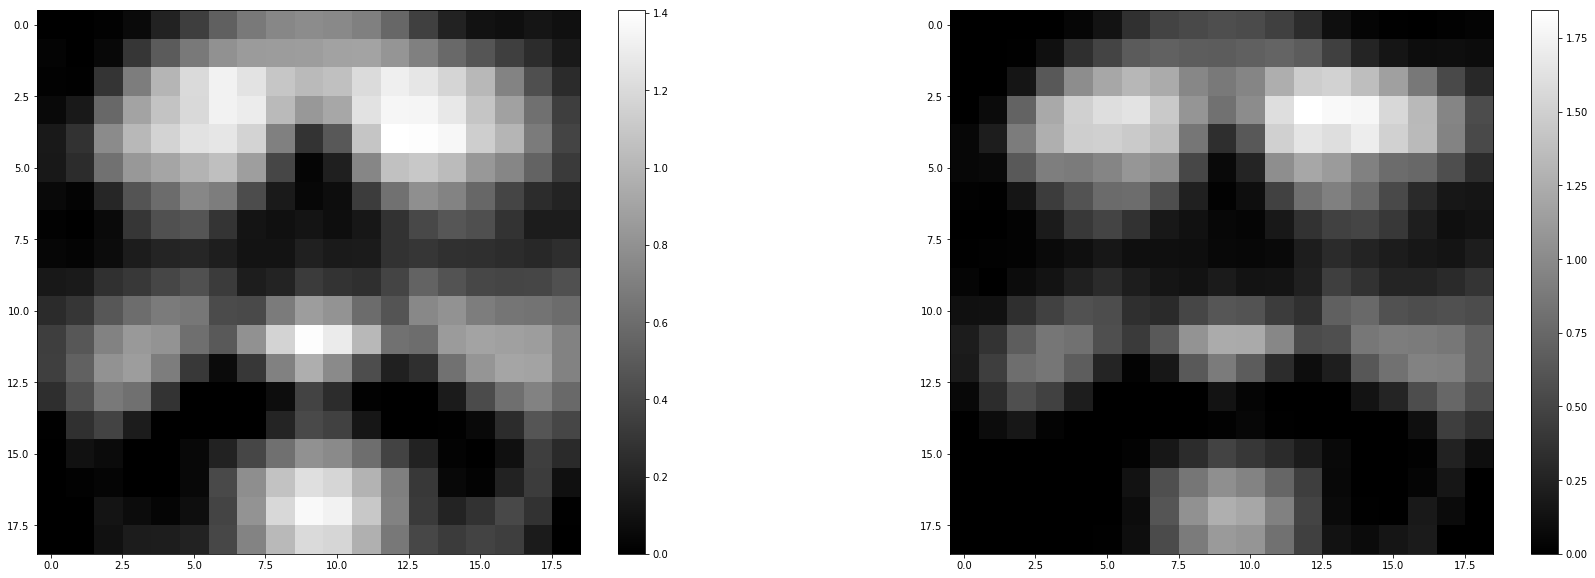

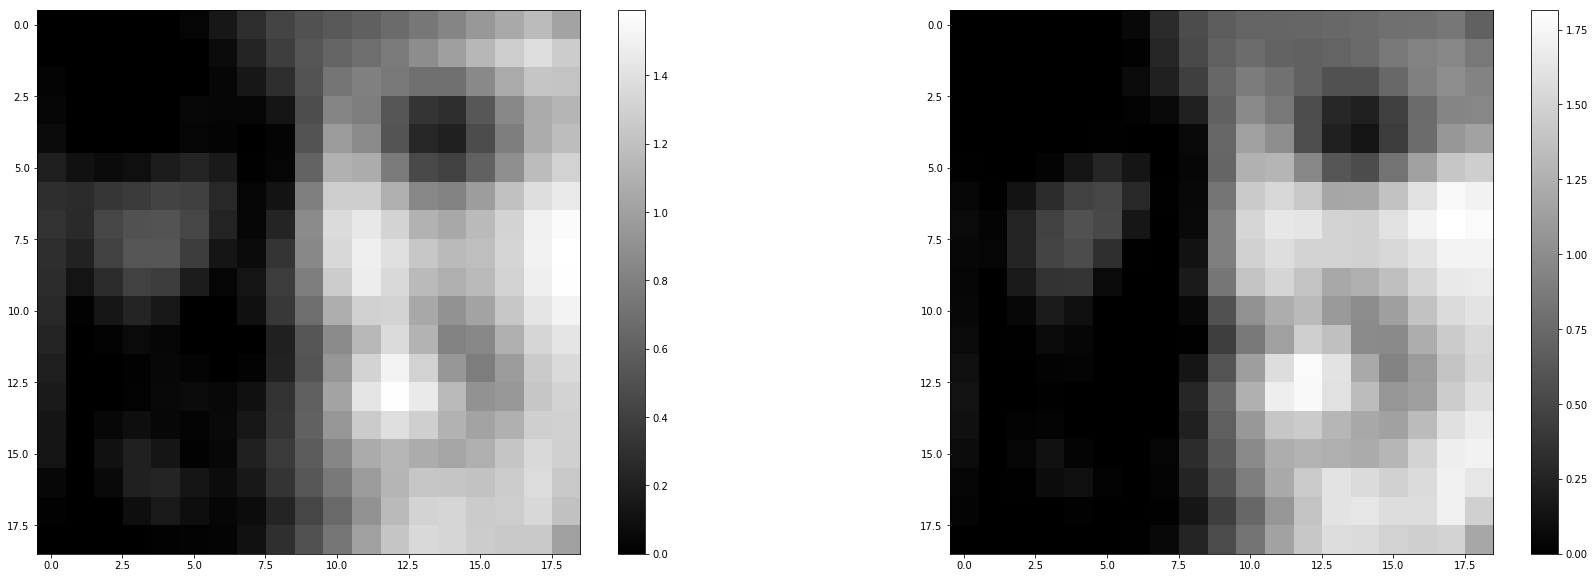

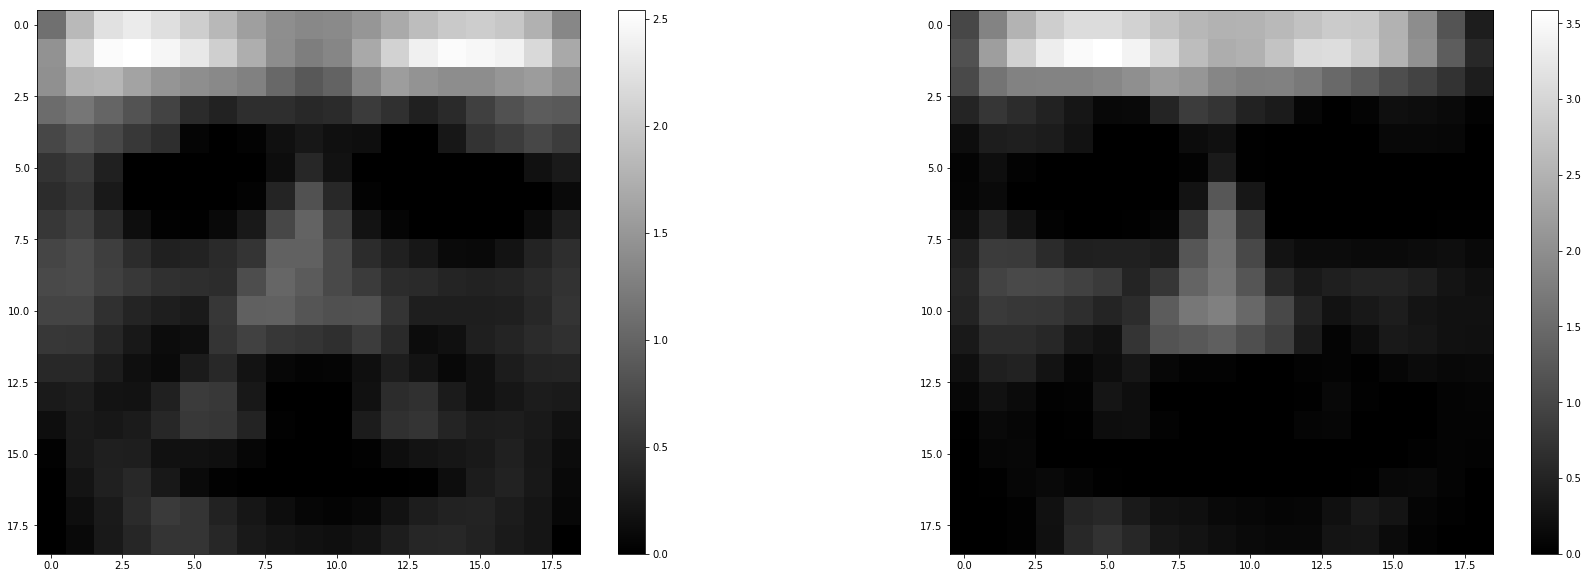

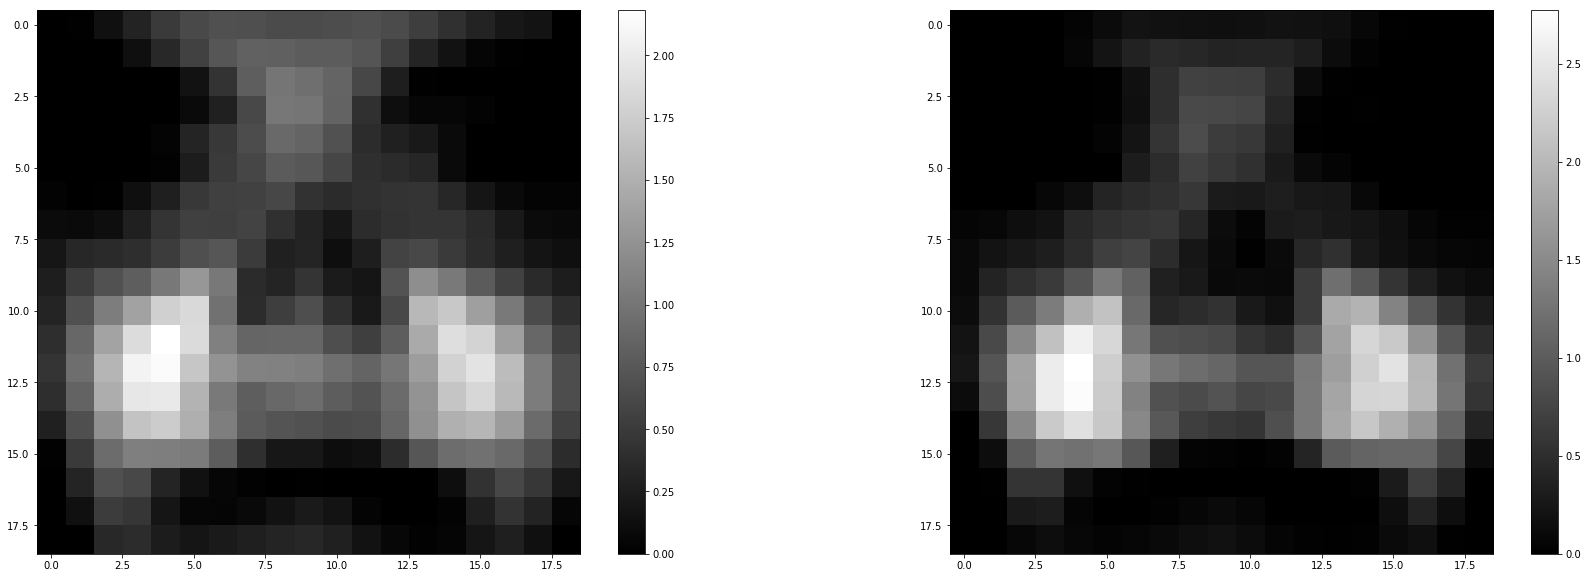

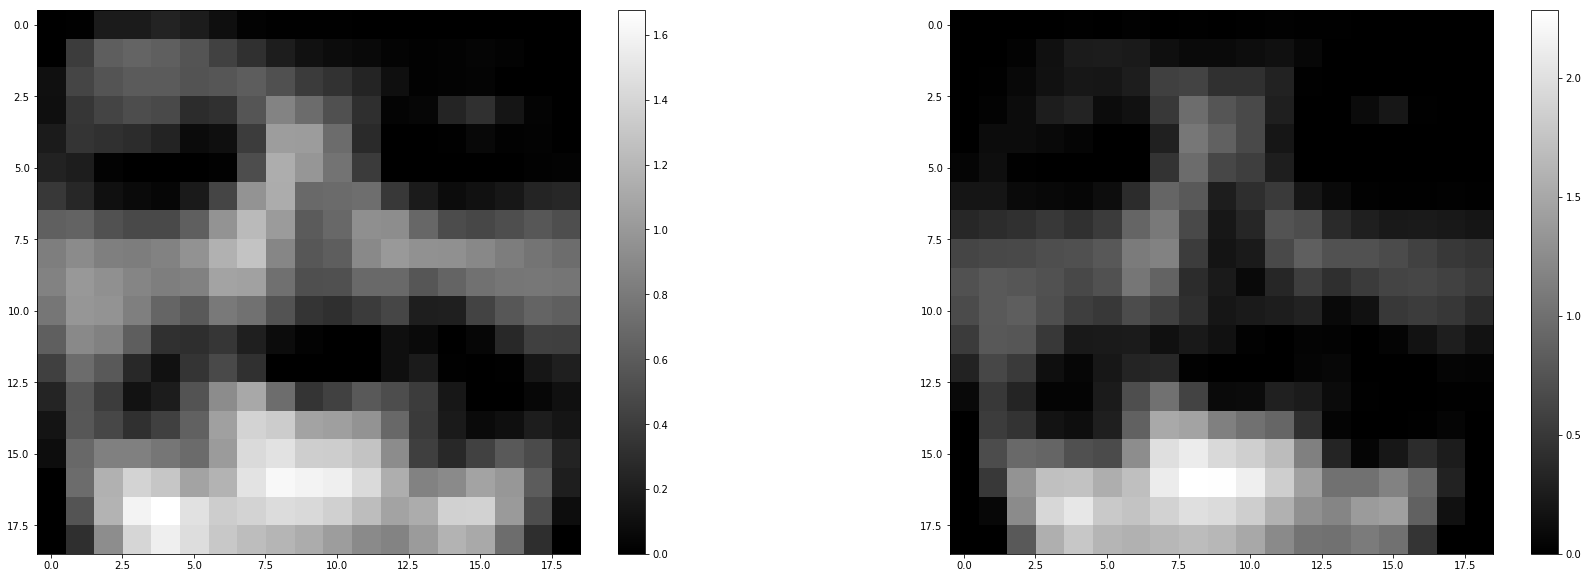

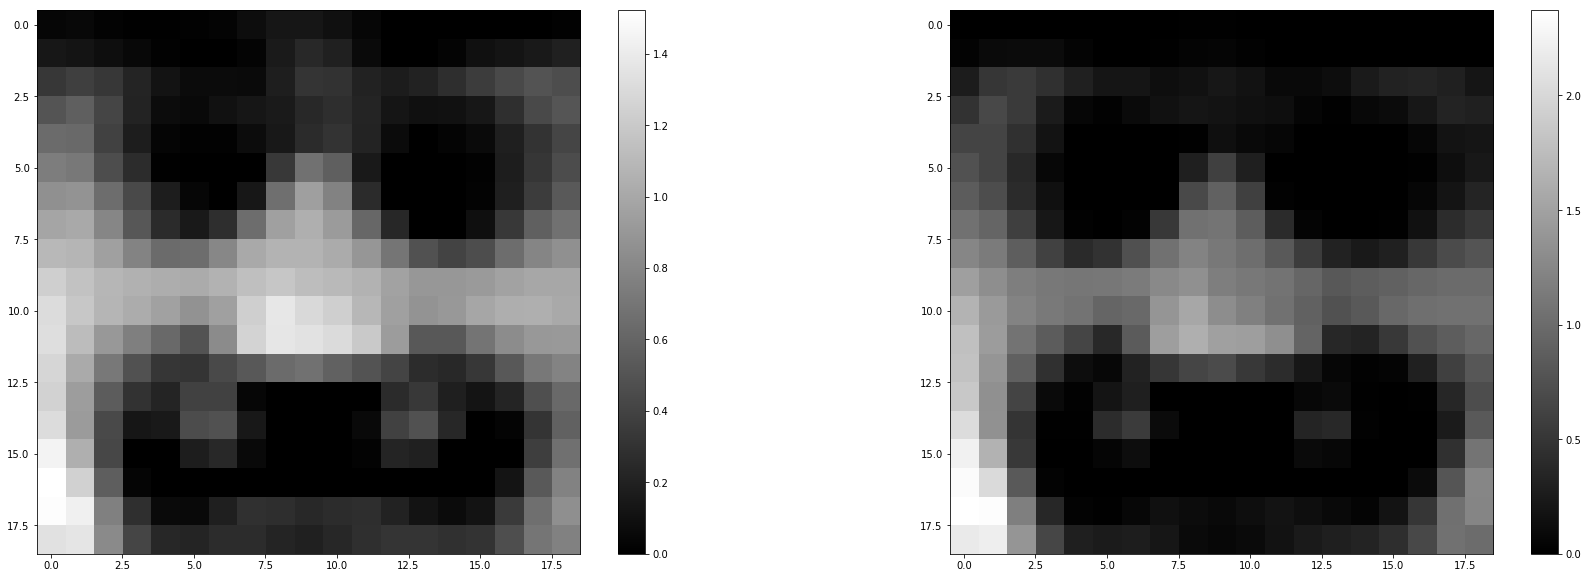

In [8]:
for i in range(rank):
    plt.figure(figsize=(30,10))
    plt.subplot(121)
    plt.imshow(Zn.T[i].reshape((19,19)), cmap='gray')
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(Zns.T[i].reshape((19,19)), cmap='gray')
    plt.colorbar()
    plt.show()

In [9]:
def plot_features(idx):
    plt.figure(figsize=(30,10))
    plt.subplot(121)
    plt.imshow(Zn.T[idx].reshape((19,19)), cmap='gray')
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(Zns.T[idx].reshape((19,19)), cmap='gray')
    plt.colorbar()
    plt.show()    

In [10]:
interact(plot_features, idx = IntSlider(min=0, max=9, value=0, continous_update=False))

interactive(children=(IntSlider(value=0, description='idx', max=9), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_features(idx)>

<img src="./images/Alg_of_dNSNMF.png">

In [18]:
def fineTuning(X, Z, S, H, num_layer,maxiter, opt_mode = 'APG'):
    itr = 0
    while itr<maxiter and num_layer>1:
        itr +=1
        B = S[0].copy()
        B = np.asarray(B)
        for i in range(num_layer-1):
            B = B.dot(Z[i+1]).dot(S[i+1])
        B = B.dot(H[-1])
        if (opt_mode == 'APG'):
            tmp, _ = APG(X.T, B.T,Z[0].T )
        else:
            tmp = MUR(X.T, B.T, Z[0].T)
        Z[0] = tmp.T
        if (itr%5 == 0):
            print(itr)
        
        A = Z[0].dot(S[0])
        for i in range(1, num_layer):
            if i>1:
                A = A.dot(Z[i-1]).dot(S[i-1])
            B = S[i].copy()
            for j in range(i+1, num_layer):
                B = B.dot(Z[j]).dot(S[j])
            B = B.dot(H[-1])       
            a,b = Z[i].shape
            if (opt_mode == 'APG'):
                tmp,_ = APG(X.flatten(), np.kron(B.T,A), Z[i].flatten())  
            else:
                tmp = MUR(X.flatten(), np.kron(B.T,A), Z[i].flatten())              
             
            Z[i] = tmp.reshape(a,b)
        
        A = Z[0].dot(S[0])
        for i in range(num_layer-1):
            A = A.dot(Z[i+1]).dot(S[i+1])
        if (opt_mode == 'APG'):
            H[-1],_  = APG(X, A, H[-1] )
        else:
            H[-1] = MUR(X, A, H[-1] )            
        X_hat = Z[0].dot(S[0])
        for i in range(1, num_layer):
            X_hat = X_hat.dot(Z[i]).dot(S[i])
        X_hat = X_hat.dot(H[-1])
        err[itr] = np.average(np.sqrt((X-X_hat)**2))
        print('Error in fine-tuning, iter: %d' %itr)
        print(err[itr])
        
    return Z, S, H, err

In [19]:
def deepNsNMF(X, rank_list, theta=0.5, maxiter = 50, opt_mode = 'APG'):
    num_layer = len(rank_list)
    Z = []
    S = []
    H = []
    
    cX = np.copy(X)
    
    ###.  PRETRAINING
    for i in range(num_layer):
        _, tZ, tH, tS, _, _ = NSNMF(cX, np.ones_like(cX), rank_list[i], theta= 0.5, maxiter = 1, opt_mode = 'MUR')
        Z.append(tZ)
        S.append(tS)
        H.append(tH)
        cX = np.copy(tH)
    
    err = np.zeros((maxiter+1))
    X_hat = Z[0].dot(S[0])
    for i in range(1, num_layer):
        X_hat = X_hat.dot(Z[i]).dot(S[i])
    X_hat = X_hat.dot(H[-1])
    err[0] = np.average(np.sqrt((X-X_hat)**2))
    print('Error before fine-tuning:')
    print(err[0])

    
    ### FINETUNING
    
    Z, S, H, err = fineTuning(X, Z, S, H, num_layer, maxiter, opt_mode)
        
    return Z, S, H, err
        
        

In [1]:
rank_list = [49, 25, 16]
Z, S, H, err = deepNsNMF(imgs, rank_list, theta=0.5, opt_mode= 'MUR')

NameError: name 'deepNsNMF' is not defined

In [ ]:
rank_list =  [49, 25, 16]
Z, S, H, err = deepNsNMF(imgs, rank_list, theta=0.5)

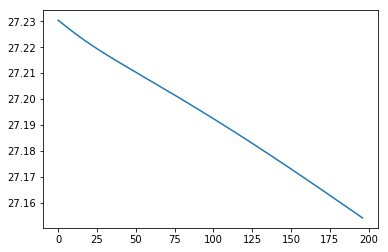

In [118]:
plt.plot(err[4:])

In [138]:
W = []
W.append(Z[0])
for i in range(len(rank_list)-1):
    W.append(W[-1].dot(S[i]).dot(Z[i+1]))
#    W.append(W[-1].dot(Z[i+1]))

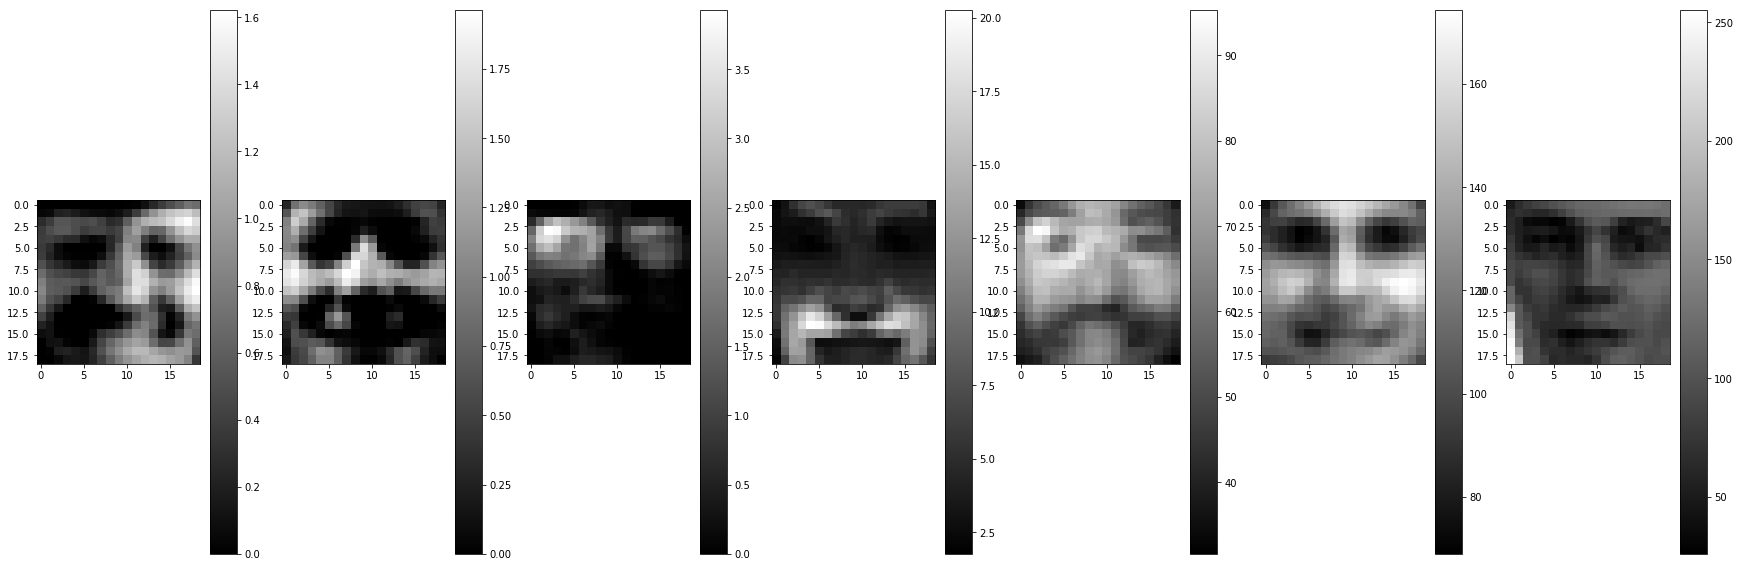

In [154]:
idx=9
plt.figure(figsize=(30,10))

plt.subplot(171)
plt.imshow(Zn.T[idx].reshape((19,19)), cmap='gray')
plt.colorbar()
plt.subplot(172)
plt.imshow(Zns.T[idx].reshape((19,19)), cmap='gray')
plt.colorbar()

plt.subplot(173)
plt.imshow(W[0].T[idx].reshape((19,19)), cmap='gray')
plt.colorbar()
plt.subplot(174)
plt.imshow(W[1].T[idx].reshape((19,19)), cmap='gray')
plt.colorbar()
plt.subplot(175)
plt.imshow(W[2].T[idx].reshape((19,19)), cmap='gray')
plt.colorbar()
plt.subplot(176)
plt.imshow(W[2].dot(S[-1]).dot(H[-1]).T[idx].reshape((19,19)), cmap='gray')
plt.colorbar()
plt.subplot(177)
plt.imshow(imgs.T[idx].reshape((19,19)), cmap='gray')
plt.colorbar()
plt.show()  